<a href="https://colab.research.google.com/github/syahvan/lung-colon-cancer/blob/main/Cancer-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lung and Colon Cancer Classification

## Load Library

In [ ]:
!pip install kaggle
!pip install split-folders

In [ ]:
from google.colab import drive
import zipfile
import os
import shutil
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
import pathlib

## Setup Dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Kaggle API credentials
with open('/content/drive/MyDrive/Kaggle/kaggle.json') as f:
    kaggle_credentials = json.load(f)

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
# Download dataset
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [00:48<00:00, 37.6MB/s]
100% 1.76G/1.76G [00:48<00:00, 38.6MB/s]


In [ ]:
zip_file = 'lung-and-colon-cancer-histopathological-images.zip'

# Unzip dataset
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
import shutil

# Membuat folder /content/dataset jika belum ada
shutil.os.makedirs('/content/dataset', exist_ok=True)

# Memindahkan folder ke /content/dataset
shutil.move('/content/lung_colon_image_set/colon_image_sets/colon_aca', '/content/dataset')
shutil.move('/content/lung_colon_image_set/colon_image_sets/colon_n', '/content/dataset')
shutil.move('/content/lung_colon_image_set/lung_image_sets/lung_aca', '/content/dataset')
shutil.move('/content/lung_colon_image_set/lung_image_sets/lung_n', '/content/dataset')
shutil.move('/content/lung_colon_image_set/lung_image_sets/lung_scc', '/content/dataset')

'/content/dataset/lung_scc'

## Data Preprocessing

In [ ]:
base_dir = '/content/dataset'
train_dir = '/content/output/train'
validation_dir = '/content/output/val'

# Pemisahan Data menjadi Training dan Validation
splitfolders.ratio(base_dir, output="output", seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 25000 files [00:09, 2525.59 files/s]


In [ ]:
# Augmentasi Data
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
# Pelabelan data menggunakan Image Data Generator berdasarkan Folder
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


## Modelling

In [ ]:
# Membangun Model Jaringan Saraf Tiruan Menggunakan model Sequential
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
# Melakukan Kompilasi Model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Membuat fitur callback
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.98) and (logs.get('val_accuracy') > 0.98)):
      print("\nMenghentikan training karena akurasi diatas 0.98!")
      self.model.stop_training = True

callbacks = Callback()

In [ ]:
# Melatih Model Jaringan Saraf Tiruan
history = model.fit(
      train_generator,
      epochs=25,
      validation_data=validation_generator,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/25
625/625 [==============================] - 444s 711ms/step - loss: 0.4430 - accuracy: 0.8059 - val_loss: 0.4611 - val_accuracy: 0.7372
Epoch 2/25
625/625 [==============================] - 499s 798ms/step - loss: 0.2371 - accuracy: 0.9069 - val_loss: 0.1543 - val_accuracy: 0.9364
Epoch 3/25
625/625 [==============================] - 429s 687ms/step - loss: 0.1923 - accuracy: 0.9230 - val_loss: 0.1334 - val_accuracy: 0.9460
Epoch 4/25
625/625 [==============================] - 424s 678ms/step - loss: 0.1309 - accuracy: 0.9493 - val_loss: 0.1070 - val_accuracy: 0.9570
Epoch 5/25
625/625 [==============================] - 427s 683ms/step - loss: 0.1208 - accuracy: 0.9530 - val_loss: 0.0761 - val_accuracy: 0.9702
Epoch 6/25
625/625 [==============================] - 409s 654ms/step - loss: 0.0943 - accuracy: 0.9635 - val_loss: 0.0693 - val_accuracy: 0.9752
Epoch 7/25
625/625 [==============================] - 411s 659ms/step - loss: 0.0863 - accuracy: 0.9681 - val_loss: 0.1198 -

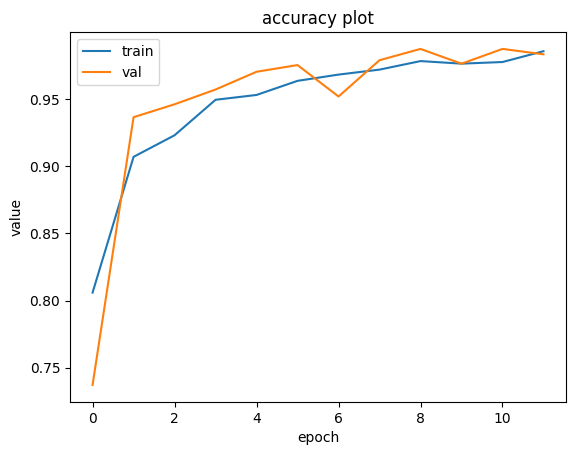

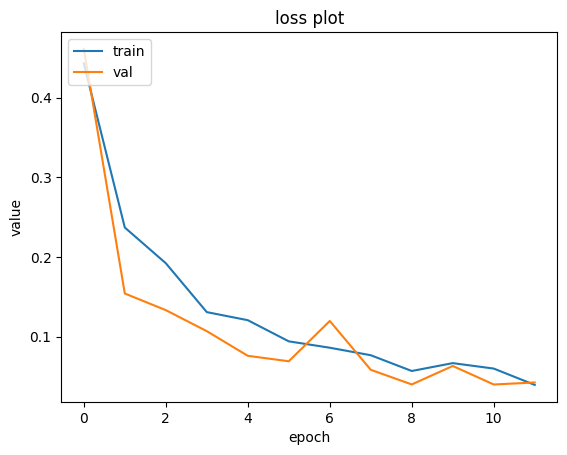

In [ ]:
# Melihat pergerakan besaran nilai akurasi Training dan Validasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy plot')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss plot')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Saving lungn.jpeg to lungn.jpeg
1/1 [==============================] - 0s 20ms/step
lungn.jpeg
Lung Benign Tissue


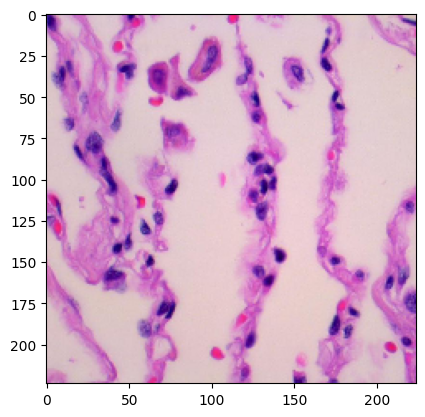

In [ ]:
#Uji Coba Model Klasifikasi Gambar
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]==1:
    print('Colon Adenocarcinoma')
  elif classes[0,1]==1:
    print('Colon Benign Tissue')
  elif classes[0,2]==1:
    print('Lung Adenocarcinoma')
  elif classes[0,3]==1:
    print('Lung Benign Tissue')
  else:
    print('Lung Squamous Cell Carcinoma')

## Mengubah Model ke Format TFLite

In [ ]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('lung-colon-cancer.tflite')
tflite_model_file.write_bytes(tflite_model)

38729320